<a href="https://colab.research.google.com/github/William10083/Yolov3Custom/blob/master/Copia_de_CNNy_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import zipfile
from google.colab import files

zip_file = files.upload()  # Selecciona el archivo ZIP del dataset TrashNet desde tu sistema local

for zip_name in zip_file.keys():
    extract_dir = '/content/'  # Ruta de la carpeta donde se extraerán los archivos

    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    print(f"El archivo ZIP '{zip_name}' se ha descomprimido en la carpeta '{extract_dir}'.")


Saving soldomestic-net.zip to soldomestic-net.zip
El archivo ZIP 'soldomestic-net.zip' se ha descomprimido en la carpeta '/content/'.


**RECORRIENDO EL DATASET TRASHNET**

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

data_folder = '/content/dataset-resized/'
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

images = []
labels = []

for category in categories:
    category_folder = os.path.join(data_folder, category)

    if os.path.isdir(category_folder):
        for filename in os.listdir(category_folder):
            file_path = os.path.join(category_folder, filename)

            if os.path.isfile(file_path) and any(filename.endswith(extension) for extension in ['.jpg', '.png']):
                image = cv2.imread(file_path)
                image = cv2.resize(image, (256, 256))

                images.append(image)
                labels.append(categories.index(category))

images = np.array(images)
labels = np.array(labels)

# Dividir los datos en conjuntos de entrenamiento, validación y prueba

# random_state = ****
# 100% = 80% / 20%
# 20% = 10% / 10%

X_train, X_val_test, y_train, y_val_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Verificar las formas de los conjuntos de datos
total_imagenes = images.shape[0]
print("Total de imágenes en el dataset:", total_imagenes)
print("Cantidad de imágenes en el conjunto de entrenamiento:", X_train.shape[0])
print("Cantidad de imágenes en el conjunto de validación:", X_val.shape[0])
print("Cantidad de imágenes en el conjunto de prueba:", X_test.shape[0])

Total de imágenes en el dataset: 2390
Cantidad de imágenes en el conjunto de entrenamiento: 1912
Cantidad de imágenes en el conjunto de validación: 239
Cantidad de imágenes en el conjunto de prueba: 239


**MODELO BASADO EN CNN CON TRASHNET SIN AUMENTO DE DATOS (PRE - TEST)**

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# Convertir las etiquetas en representación one-hot
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_val = label_binarizer.transform(y_val)
y_test = label_binarizer.transform(y_test)

# Normalizar los valores de píxeles entre 0 y 1
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Definir la arquitectura del modelo CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(categories), activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred, target_names=categories)
print(report)

Epoch 1/30
60/60 [==============================] - 16s 87ms/step - loss: 1.9117 - accuracy: 0.3708 - val_loss: 1.1581 - val_accuracy: 0.5272
Epoch 2/30
60/60 [==============================] - 3s 58ms/step - loss: 1.0456 - accuracy: 0.5821 - val_loss: 1.0596 - val_accuracy: 0.6109
Epoch 3/30
60/60 [==============================] - 3s 56ms/step - loss: 0.7844 - accuracy: 0.7134 - val_loss: 1.1890 - val_accuracy: 0.5565
Epoch 4/30
60/60 [==============================] - 3s 58ms/step - loss: 0.5384 - accuracy: 0.8096 - val_loss: 1.2292 - val_accuracy: 0.5732
Epoch 5/30
60/60 [==============================] - 4s 60ms/step - loss: 0.2947 - accuracy: 0.9074 - val_loss: 1.3787 - val_accuracy: 0.5732
Epoch 6/30
60/60 [==============================] - 3s 56ms/step - loss: 0.1946 - accuracy: 0.9472 - val_loss: 1.6836 - val_accuracy: 0.5607
Epoch 7/30
60/60 [==============================] - 3s 56ms/step - loss: 0.1275 - accuracy: 0.9603 - val_loss: 1.7480 - val_accuracy: 0.5481
Epoch 8/30
6

**GRAFICO DE PERDIDA Y EXACTITUD DURANTE EL ENTRENAMIENTO (PRE TEST)**

In [ ]:
import matplotlib.pyplot as plt

# Obtener las métricas de pérdida y precisión del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Crear gráficos de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Crear gráficos de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**MATRIZ DE CONFUSION (PRE TEST)**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Crear una representación gráfica de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión')
plt.show()

**DATA AUGMENTATION**

Total de imagenes despues de aplicar aumento de datos:

*num_data_aug_img = num_images * (num_transformaciones + 1)*

**Muestra de imagenes con transformaciones**

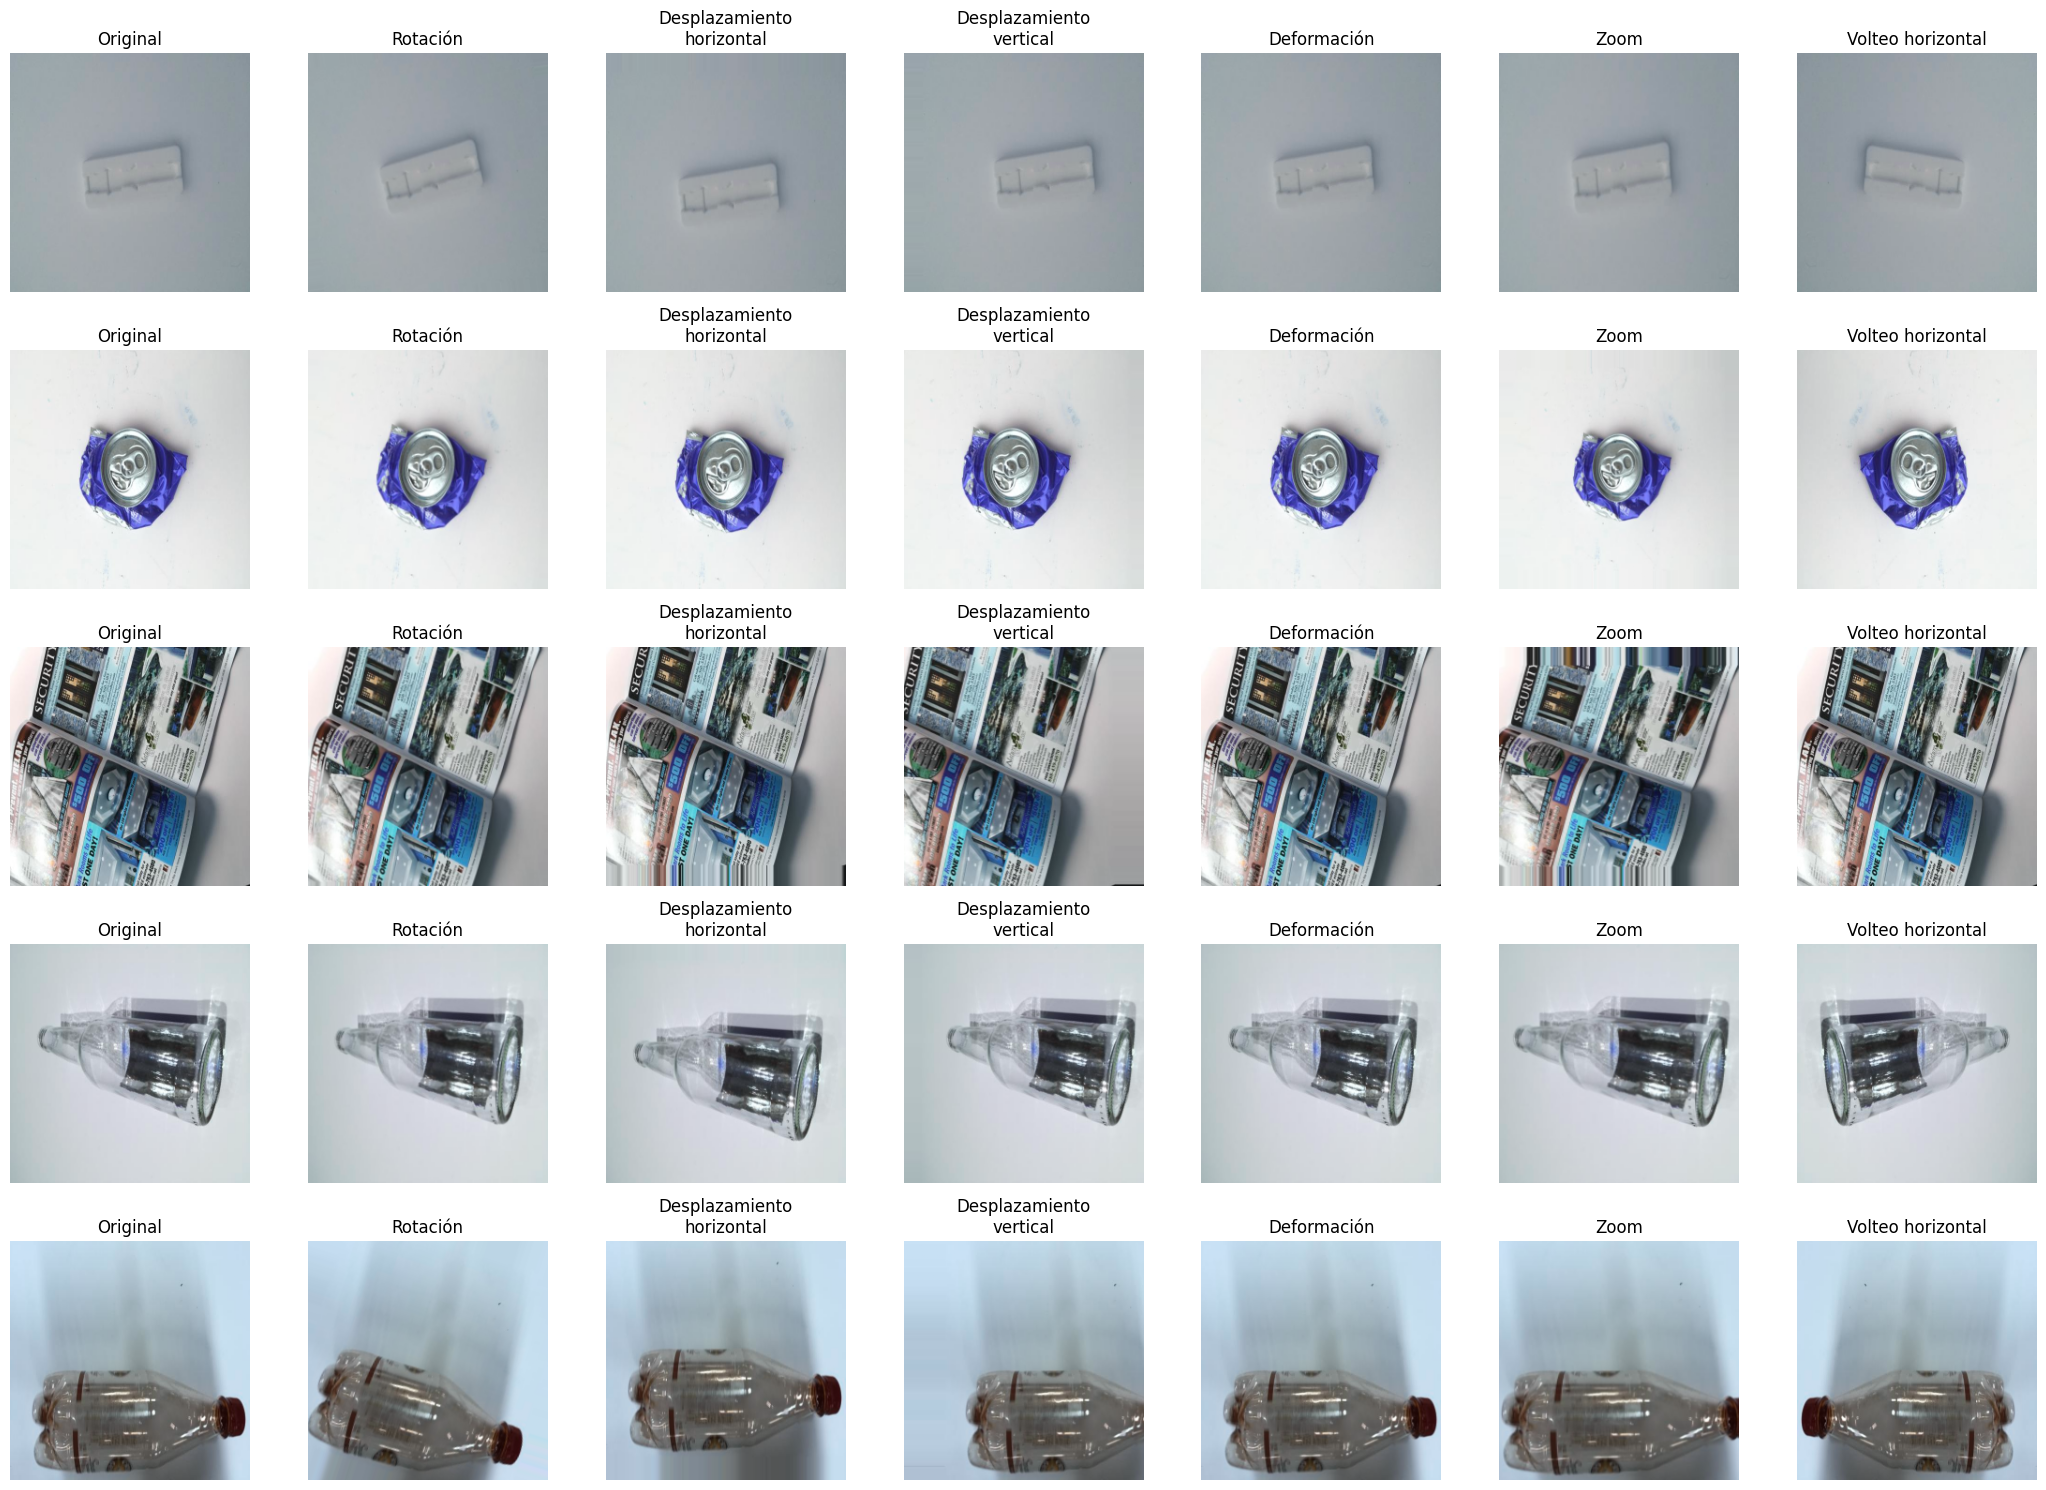

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Selecciona algunas imágenes de entrenamiento para visualizar
sample_indices = [0, 1, 2, 3, 4]  # Cambia los índices según las imágenes que quieras visualizar

# Definir los nombres de las transformaciones
transform_names = [
    "Rotación",
    "Desplazamiento horizontal",
    "Desplazamiento vertical",
    "Deformación",
    "Zoom",
    "Volteo horizontal"
]

# Crea un generador de imágenes con una transformación específica en cada iteración
transformations = [
    ImageDataGenerator(rotation_range=20),
    ImageDataGenerator(width_shift_range=0.2),
    ImageDataGenerator(height_shift_range=0.2),
    ImageDataGenerator(shear_range=0.2),
    ImageDataGenerator(zoom_range=0.2),
    ImageDataGenerator(horizontal_flip=True)
]

# Preprocesa las imágenes para ser compatibles con el generador
sample_images = X_train[sample_indices]
sample_images = sample_images.astype('float32') / 255.0

# Genera imágenes transformadas para cada transformación y cada imagen
transformed_images = []

for datagen in transformations:
    for sample_image in sample_images:
        batch = np.expand_dims(sample_image, axis=0)
        transformed_batch = datagen.flow(batch, batch_size=1, shuffle=False).next()
        transformed_image = transformed_batch[0]
        transformed_images.append(transformed_image)

# Configuración del gráfico
rows = len(sample_indices)
columns = len(transformations) + 1
fig, axes = plt.subplots(rows, columns, figsize=(columns * 3, rows * 3))

for i, sample_image in enumerate(sample_images):
    axes[i, 0].imshow(sample_image)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    for j, (transformed_image, transform_name) in enumerate(zip(transformed_images[i::rows], transform_names), start=1):
        if "Desplazamiento vertical" in transform_name:
            transform_name = "Desplazamiento\nvertical"  # Agrega un salto de línea
        if "Desplazamiento horizontal" in transform_name:
            transform_name = "Desplazamiento\nhorizontal"  # Agrega un salto de línea
        axes[i, j].imshow(transformed_image)
        axes[i, j].set_title(transform_name)
        axes[i, j].axis("off")

plt.tight_layout()
# Guardar la imagen resultante
plt.savefig('result.png')

plt.show()


**RECORRIDO DE DATASET PROPIO**

In [18]:
import os
import cv2
import numpy as np

main_folder = '/content/soldomestic-net'  # Ruta a la carpeta principal
subfolders = ['train', 'validation', 'test']
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

# Corrige el bucle de lectura de imágenes
for subfolder in subfolders:
    for category in categories:
        category_folder = os.path.join(main_folder, subfolder, category)

        if os.path.isdir(category_folder):
            for filename in os.listdir(category_folder):
                file_path = os.path.join(category_folder, filename)

                if os.path.isfile(file_path) and filename.lower().endswith(('.jpg', '.png')):
                    image = cv2.imread(file_path)
                    image = cv2.resize(image, (256, 256))

                    if subfolder == 'train':
                        X_train.append(image)
                        y_train.append(categories.index(category))
                    elif subfolder == 'validation':
                        X_val.append(image)
                        y_val.append(categories.index(category))
                    elif subfolder == 'test':
                        X_test.append(image)
                        y_test.append(categories.index(category))

# Convierte las listas de imágenes y etiquetas en arrays NumPy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Verificar las formas de los conjuntos de datos
print("Cantidad de imágenes en el conjunto de entrenamiento:", X_train.shape[0])
print("Cantidad de imágenes en el conjunto de validación:", X_val.shape[0])
print("Cantidad de imágenes en el conjunto de prueba:", X_test.shape[0])

Cantidad de imágenes en el conjunto de entrenamiento: 414
Cantidad de imágenes en el conjunto de validación: 50
Cantidad de imágenes en el conjunto de prueba: 50


**MODELO DE CNN CON MI DATASET CON AUMENTO DE DATOS (PRE - TEST)**

In [6]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# Convertir las etiquetas en representación one-hot
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_val = label_binarizer.transform(y_val)
y_test = label_binarizer.transform(y_test)

# Normalizar los valores de píxeles entre 0 y 1
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Aplicar aumento de datos a las imágenes de entrenamiento
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
datagen.fit(X_train)

# Definir la arquitectura del modelo CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(categories), activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
#model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Entrenar el modelo con aumento de datos
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=30,
                    validation_data=(X_val, y_val))

# Guardar el historial
# history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred, target_names=categories)
# report = classification_report(y_true, y_pred, target_names=categories, zero_division=1)
print(report)


Epoch 1/30
13/13 [==============================] - 8s 438ms/step - loss: 6.7336 - accuracy: 0.2101 - val_loss: 1.6752 - val_accuracy: 0.2000
Epoch 2/30
13/13 [==============================] - 6s 445ms/step - loss: 1.4764 - accuracy: 0.3478 - val_loss: 1.3609 - val_accuracy: 0.4800
Epoch 3/30
13/13 [==============================] - 7s 517ms/step - loss: 1.2526 - accuracy: 0.5169 - val_loss: 1.1442 - val_accuracy: 0.5200
Epoch 4/30
13/13 [==============================] - 6s 421ms/step - loss: 1.1006 - accuracy: 0.5725 - val_loss: 1.0229 - val_accuracy: 0.6000
Epoch 5/30
13/13 [==============================] - 7s 513ms/step - loss: 0.9959 - accuracy: 0.6256 - val_loss: 1.0298 - val_accuracy: 0.5800
Epoch 6/30
13/13 [==============================] - 6s 421ms/step - loss: 0.9272 - accuracy: 0.6425 - val_loss: 1.0044 - val_accuracy: 0.6400
Epoch 7/30
13/13 [==============================] - 6s 454ms/step - loss: 0.8796 - accuracy: 0.7150 - val_loss: 0.9236 - val_accuracy: 0.6600
Epoch 

**GRAFICO DE PERDIDA Y EXACTITUD DURANTE EL ENTRENAMIENTO (PRE TEST)**

In [ ]:
import matplotlib.pyplot as plt

# Obtener las métricas de pérdida y precisión del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Crear gráficos de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Crear gráficos de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**MATRIZ DE CONFUSION (PRE TEST)**

2/2 [==============================] - 0s 23ms/step


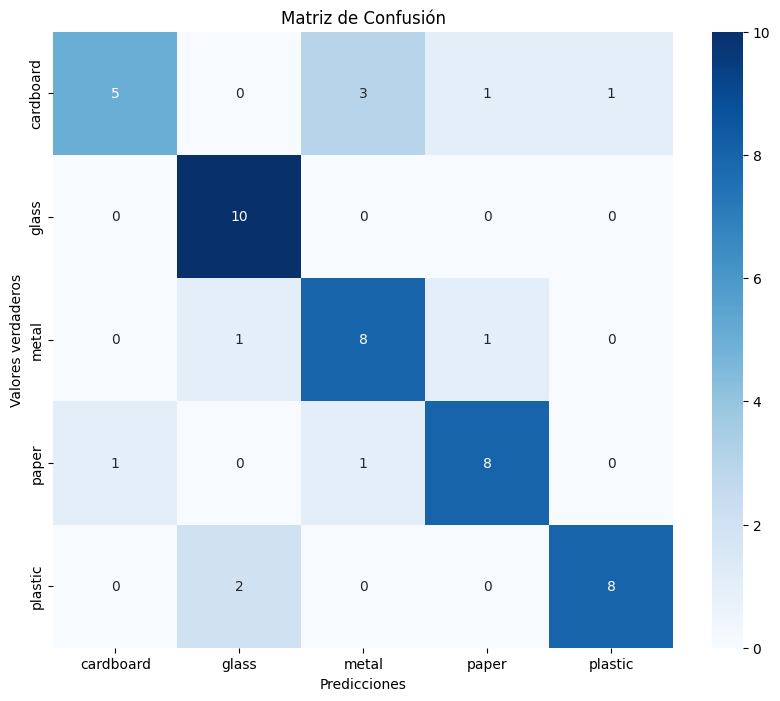

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Crear una representación gráfica de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión')
plt.show()

**POST - TEST**

**MODELO PROPUESTO CON MI DATASET CON AUMENTO DE DATOS CON OPTUNA (POST - TEST)**

In [13]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.metrics import accuracy_score  # Importa accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
import optuna

# Realizar la conversión one-hot encoding y la normalización fuera de la función
y_train_onehot = label_binarizer.transform(y_train)
y_val_onehot = label_binarizer.transform(y_val)
y_test_onehot = label_binarizer.transform(y_test)

X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0
X_test_normalized = X_test / 255.0

def create_model(trial):
    model = models.Sequential()
    model.add(layers.Conv2D(trial.suggest_int('conv1_units', 16, 64), (3, 3), input_shape=(256, 256, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(trial.suggest_int('conv2_units', 16, 64), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(trial.suggest_int('conv3_units', 16, 64), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(trial.suggest_int('conv4_units', 16, 64), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(trial.suggest_int('conv5_units', 16, 64), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(trial.suggest_float('dropout', 0.1, 0.5)))
    model.add(layers.Flatten())
    model.add(layers.Dense(trial.suggest_int('dense_units', 128, 1024), activation='relu'))
    model.add(layers.Dense(len(categories), activation='softmax'))

    optimizer = Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def objective(trial):
    model = create_model(trial)

    history = model.fit(datagen.flow(X_train_normalized, y_train_onehot, batch_size=32),
                        steps_per_epoch=len(X_train_normalized) // 32,
                        epochs=40,
                        validation_data=(X_val_normalized, y_val_onehot),
                        verbose=1)  # Cambia a verbose=1 si deseas ver el progreso

    # Calcula las métricas para la evaluación
    y_pred = model.predict(X_val_normalized)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_val_classes = np.argmax(y_val_onehot, axis=1)

    accuracy = accuracy_score(y_val_classes, y_pred_classes)
    recall = recall_score(y_val_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')
    val_loss = history.history['val_loss'][-1]

    # Maximiza la precisión y el recall, y minimiza el val_loss
    return accuracy + recall + f1 - val_loss

study = optuna.create_study(direction='maximize')  # Puedes cambiar a 'minimize' si buscas minimizar una métrica
study.optimize(objective, n_trials=10)  # Ajusta el número de ensayos según tus recursos

best_trial = study.best_trial
best_params = best_trial.params

print("Best trial:")
print(best_params)

best_model = create_model(best_trial)

# Entrena el modelo con los mejores hiperparámetros
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
datagen.fit(X_train)

best_model.fit(datagen.flow(X_train, y_train, batch_size=32),
               steps_per_epoch=len(X_train) // 32,
               epochs=50,
               validation_data=(X_val, y_val))

# Evalúa el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred, target_names=categories)
print(report)


[I 2023-10-28 03:32:05,237] A new study created in memory with name: no-name-84532e1d-2788-44a1-bffa-a669c514c317
<ipython-input-23-93a60f70d0a3>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2))


Epoch 1/40
12/12 [==============================] - 10s 503ms/step - loss: 1.5975 - accuracy: 0.2042 - val_loss: 1.5671 - val_accuracy: 0.2800
Epoch 2/40
12/12 [==============================] - 6s 504ms/step - loss: 1.4422 - accuracy: 0.4346 - val_loss: 1.4694 - val_accuracy: 0.3200
Epoch 3/40
12/12 [==============================] - 8s 660ms/step - loss: 1.3173 - accuracy: 0.4712 - val_loss: 1.5376 - val_accuracy: 0.2800
Epoch 4/40
12/12 [==============================] - 5s 424ms/step - loss: 1.2886 - accuracy: 0.4661 - val_loss: 1.3049 - val_accuracy: 0.4600
Epoch 5/40
12/12 [==============================] - 6s 540ms/step - loss: 1.1880 - accuracy: 0.5157 - val_loss: 1.2348 - val_accuracy: 0.5400
Epoch 6/40
12/12 [==============================] - 5s 429ms/step - loss: 1.1299 - accuracy: 0.5314 - val_loss: 1.3829 - val_accuracy: 0.4600
Epoch 7/40
12/12 [==============================] - 6s 450ms/step - loss: 1.1342 - accuracy: 0.5445 - val_loss: 1.2127 - val_accuracy: 0.4400
Epoch

[I 2023-10-28 03:37:34,776] Trial 0 finished with value: 1.7226137547841809 and parameters: {'conv1_units': 17, 'conv2_units': 38, 'conv3_units': 23, 'conv4_units': 62, 'conv5_units': 33, 'dropout': 0.2876567518442784, 'dense_units': 156, 'learning_rate': 0.0005545116220712947}. Best is trial 0 with value: 1.7226137547841809.
<ipython-input-23-93a60f70d0a3>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2))


Epoch 1/40
12/12 [==============================] - 12s 703ms/step - loss: 1.6092 - accuracy: 0.2120 - val_loss: 1.6054 - val_accuracy: 0.3000
Epoch 2/40
12/12 [==============================] - 6s 456ms/step - loss: 1.6073 - accuracy: 0.2120 - val_loss: 1.6016 - val_accuracy: 0.2000
Epoch 3/40
12/12 [==============================] - 6s 463ms/step - loss: 1.6024 - accuracy: 0.1990 - val_loss: 1.5991 - val_accuracy: 0.2000
Epoch 4/40
12/12 [==============================] - 7s 576ms/step - loss: 1.6005 - accuracy: 0.2042 - val_loss: 1.5956 - val_accuracy: 0.2400
Epoch 5/40
12/12 [==============================] - 6s 469ms/step - loss: 1.5915 - accuracy: 0.2435 - val_loss: 1.5910 - val_accuracy: 0.2200
Epoch 6/40
12/12 [==============================] - 6s 464ms/step - loss: 1.5922 - accuracy: 0.2240 - val_loss: 1.5852 - val_accuracy: 0.2200
Epoch 7/40
12/12 [==============================] - 7s 571ms/step - loss: 1.5819 - accuracy: 0.2356 - val_loss: 1.5786 - val_accuracy: 0.2200
Epoch

2/2 [==============================] - 0s 14ms/step


[I 2023-10-28 03:42:58,844] Trial 1 finished with value: 1.0645464295745874 and parameters: {'conv1_units': 55, 'conv2_units': 32, 'conv3_units': 51, 'conv4_units': 27, 'conv5_units': 29, 'dropout': 0.20303811390840554, 'dense_units': 413, 'learning_rate': 3.899021716079138e-05}. Best is trial 0 with value: 1.7226137547841809.
<ipython-input-23-93a60f70d0a3>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2))


Epoch 1/40
12/12 [==============================] - 83s 803ms/step - loss: 3.3519 - accuracy: 0.1832 - val_loss: 1.6097 - val_accuracy: 0.2000
Epoch 2/40
12/12 [==============================] - 5s 424ms/step - loss: 1.6123 - accuracy: 0.1780 - val_loss: 1.6098 - val_accuracy: 0.2000
Epoch 3/40
12/12 [==============================] - 7s 534ms/step - loss: 1.6114 - accuracy: 0.1832 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 4/40
12/12 [==============================] - 6s 455ms/step - loss: 1.6101 - accuracy: 0.2016 - val_loss: 1.6097 - val_accuracy: 0.2000
Epoch 5/40
12/12 [==============================] - 5s 441ms/step - loss: 1.6100 - accuracy: 0.1728 - val_loss: 1.6097 - val_accuracy: 0.2000
Epoch 6/40
12/12 [==============================] - 6s 507ms/step - loss: 1.6094 - accuracy: 0.2120 - val_loss: 1.6100 - val_accuracy: 0.2000
Epoch 7/40
12/12 [==============================] - 5s 432ms/step - loss: 1.6091 - accuracy: 0.2094 - val_loss: 1.6101 - val_accuracy: 0.2000
Epoch

2/2 [==============================] - 0s 11ms/step


[I 2023-10-28 03:49:24,814] Trial 2 finished with value: -1.1439630111058552 and parameters: {'conv1_units': 28, 'conv2_units': 23, 'conv3_units': 30, 'conv4_units': 48, 'conv5_units': 53, 'dropout': 0.12548907700686956, 'dense_units': 156, 'learning_rate': 0.008117013410838038}. Best is trial 0 with value: 1.7226137547841809.
<ipython-input-23-93a60f70d0a3>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2))


Epoch 1/40
12/12 [==============================] - 13s 616ms/step - loss: 1.6099 - accuracy: 0.2042 - val_loss: 1.6093 - val_accuracy: 0.2600
Epoch 2/40
12/12 [==============================] - 6s 506ms/step - loss: 1.6081 - accuracy: 0.1963 - val_loss: 1.6076 - val_accuracy: 0.2400
Epoch 3/40
12/12 [==============================] - 6s 519ms/step - loss: 1.6064 - accuracy: 0.2277 - val_loss: 1.6059 - val_accuracy: 0.3000
Epoch 4/40
12/12 [==============================] - 5s 440ms/step - loss: 1.6051 - accuracy: 0.2330 - val_loss: 1.6040 - val_accuracy: 0.3200
Epoch 5/40
 7/12 [================>.............] - ETA: 49s - loss: 1.6038 - accuracy: 0.2477

In [ ]:

from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

for i, category in enumerate(categories):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i, :].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - TP - FP - FN

    print(f'{category.upper()}')
    print(f'Verdaderos Positivos (TP) = {TP}, Falsos Negativos (FN) = {FN}, Falsos Positivos (FP) = {FP}, Verdaderos Negativos (TN) = {TN}\n')


CARDBOARD
Verdaderos Positivos (TP) = 33, Falsos Negativos (FN) = 7, Falsos Positivos (FP) = 6, Verdaderos Negativos (TN) = 193

GLASS
Verdaderos Positivos (TP) = 41, Falsos Negativos (FN) = 15, Falsos Positivos (FP) = 13, Verdaderos Negativos (TN) = 170

METAL
Verdaderos Positivos (TP) = 28, Falsos Negativos (FN) = 15, Falsos Positivos (FP) = 10, Verdaderos Negativos (TN) = 186

PAPER
Verdaderos Positivos (TP) = 50, Falsos Negativos (FN) = 6, Falsos Positivos (FP) = 27, Verdaderos Negativos (TN) = 156

PLASTIC
Verdaderos Positivos (TP) = 27, Falsos Negativos (FN) = 17, Falsos Positivos (FP) = 4, Verdaderos Negativos (TN) = 191



In [ ]:
X_train.shape  # Verifica las dimensiones de X_train
y_train.shape  # Verifica las dimensiones de y_train
X_val.shape

(239, 256, 256, 3)

**GUARDADO DE MODELO**

In [ ]:
# Especifica el directorio donde deseas guardar el modelo
ruta_guardado = "/content/MODELO/"

# Guarda el modelo en el directorio especificado
model.save(ruta_guardado)

print(f"El modelo ha sido guardado en {ruta_guardado}")

El modelo ha sido guardado en /content/MODELO/


In [ ]:
TP = sum((y_true[i] == 1) and (y_pred[i] == 1) for i in range(len(y_true)))

NameError: ignored

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular las métricas
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Crear el DataFrame con los resultados
df_resultados = pd.DataFrame({'Métrica': ['Precisión', 'Recall', 'Exactitud', 'F1'],
                              'Valor': [precision, recall, accuracy, f1]})

# Imprimir la tabla de resultados
print(df_resultados)

8/8 [==============================] - 0s 22ms/step
     Métrica     Valor
0  Precisión  0.772515
1     Recall  0.742960
2  Exactitud  0.748954
3         F1  0.748827


**GUARDADO DE IMAGEN DE LA ARQUITECTURA UTILIZANDO VISUALKERAS**

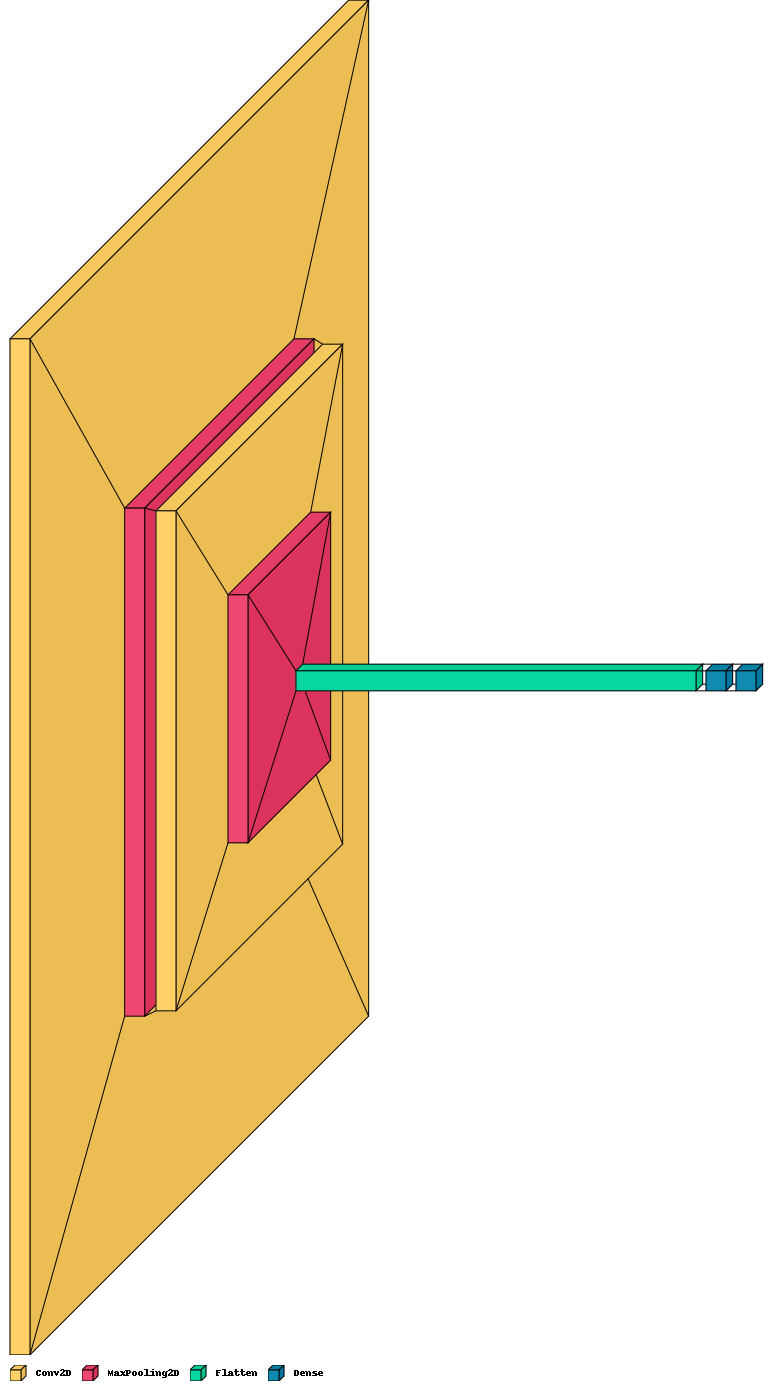

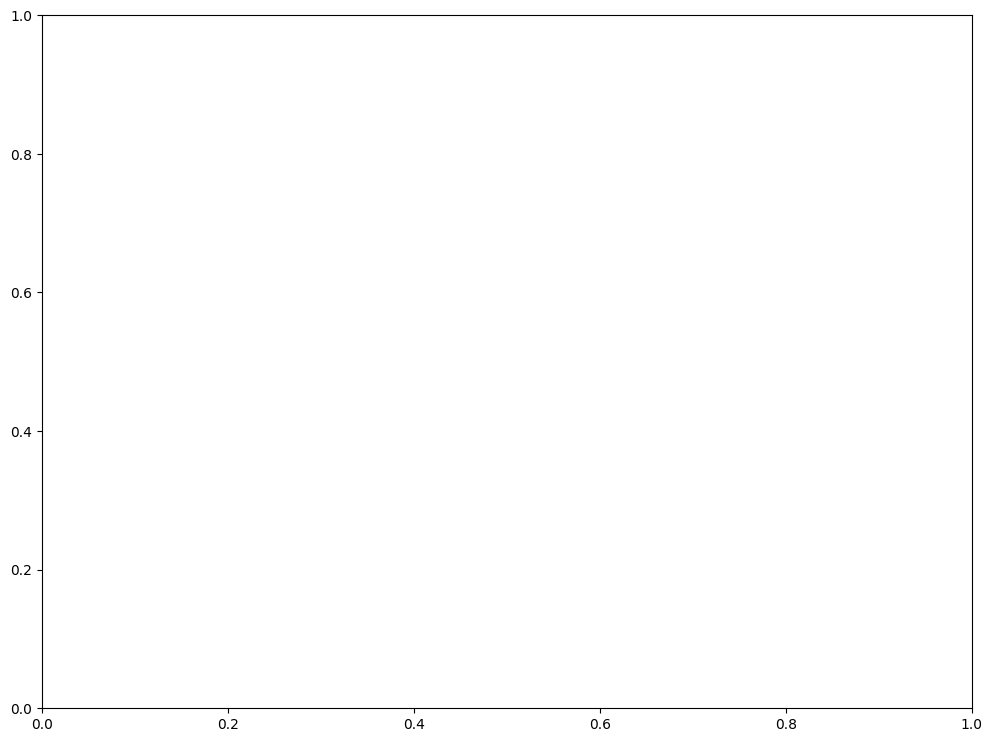

In [ ]:
import visualkeras
import matplotlib.pyplot as plt

# Visualizar la arquitectura del modelo con leyenda y descripciones de capa
vis = visualkeras.layered_view(model, legend=True)

# Configurar el tamaño de la figura
fig, ax = plt.subplots(figsize=(12, 9))

# Guardar la figura en un archivo
vis.save('arquitectura-CNN-sinMOD.png')

# Mostrar la visualización
vis.show()

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 64)                1

**MODELO BASADO EN CNN MODIFICADO, ALGORITMO MODIFICADO**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convertir las etiquetas en representación one-hot
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)

# Normalizar los valores de píxeles entre 0 y 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Definir la arquitectura del modelo CNN mejorado
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(categories), activation='softmax'))

# Compilar el modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred, target_names=categories)
print(report)


Epoch 1/50
60/60 [==============================] - 31s 253ms/step - loss: 2.4874 - accuracy: 0.3018 - val_loss: 2.0577 - val_accuracy: 0.4351
Epoch 2/50
60/60 [==============================] - 10s 173ms/step - loss: 1.9984 - accuracy: 0.4273 - val_loss: 1.8547 - val_accuracy: 0.4561
Epoch 3/50
60/60 [==============================] - 10s 163ms/step - loss: 1.8025 - accuracy: 0.4676 - val_loss: 1.7062 - val_accuracy: 0.5000
Epoch 4/50
60/60 [==============================] - 10s 171ms/step - loss: 1.6339 - accuracy: 0.5282 - val_loss: 1.5826 - val_accuracy: 0.5607
Epoch 5/50
60/60 [==============================] - 10s 163ms/step - loss: 1.5257 - accuracy: 0.5497 - val_loss: 1.5111 - val_accuracy: 0.6151
Epoch 6/50
60/60 [==============================] - 10s 163ms/step - loss: 1.4270 - accuracy: 0.5826 - val_loss: 1.4713 - val_accuracy: 0.5690
Epoch 7/50
60/60 [==============================] - 10s 175ms/step - loss: 1.3314 - accuracy: 0.6297 - val_loss: 1.3905 - val_accuracy: 0.6318

**GUARDADO DE IMAGEN DE LA ARQUITECTURA UTILIZANDO VISUALKERAS**

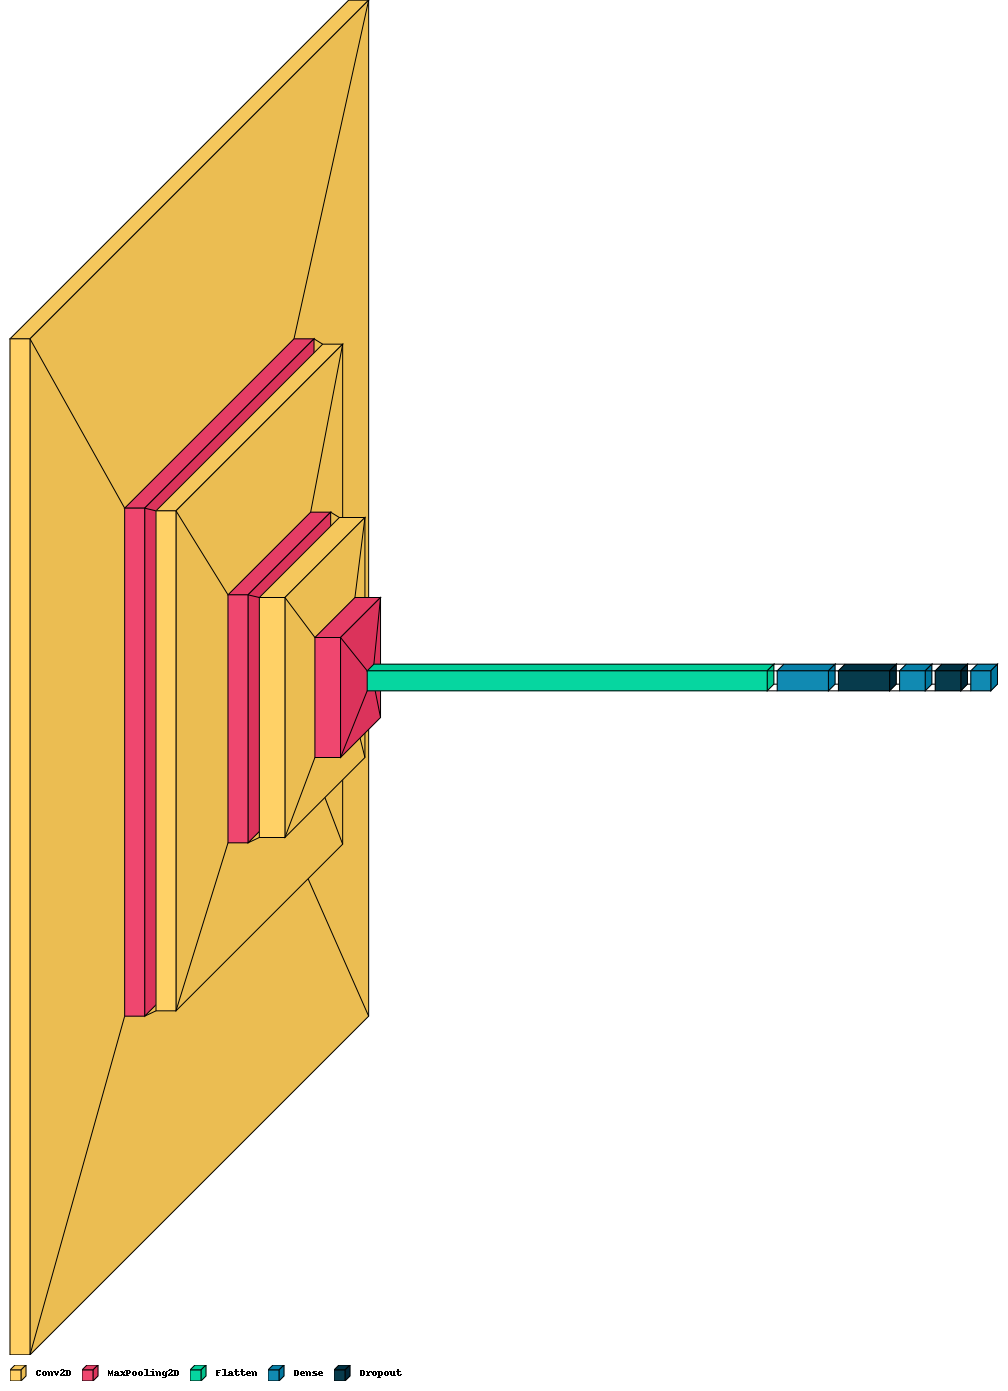

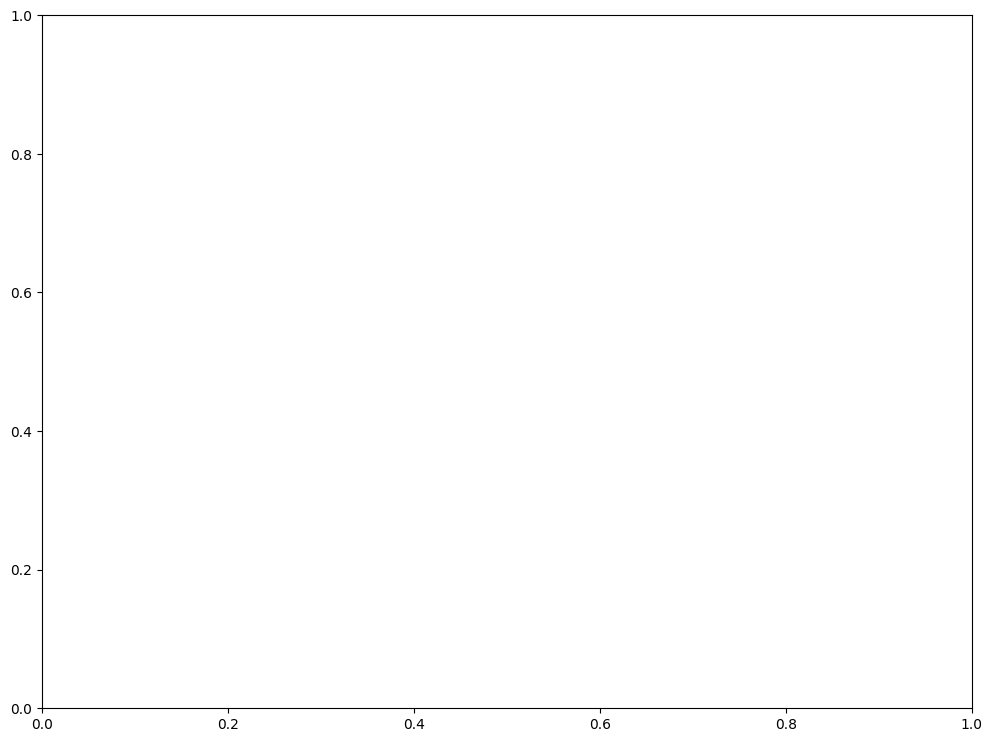

In [ ]:
import visualkeras
import matplotlib.pyplot as plt

# Visualizar la arquitectura del modelo con leyenda y descripciones de capa
vis = visualkeras.layered_view(model, legend=True)

# Configurar el tamaño de la figura
fig, ax = plt.subplots(figsize=(12, 9))

# Guardar la figura en un archivo
vis.save('modelo_visualizado.png')

# Mostrar la visualización
vis.show()


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_val_test, y_train, y_val_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Convertir las etiquetas en representación one-hot
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_val = label_binarizer.transform(y_val)
y_test = label_binarizer.transform(y_test)

# Normalizar los valores de píxeles entre 0 y 1
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Aplicar aumento de datos a las imágenes de entrenamiento
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
datagen.fit(X_train)

# Definir la arquitectura del modelo
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(len(categories), activation='softmax'))

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con aumento de datos
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=50,
                    validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred, target_names=categories)
print(report)

Epoch 1/50
59/59 [==============================] - 43s 504ms/step - loss: 1.4584 - accuracy: 0.3537 - val_loss: 1.3750 - val_accuracy: 0.3682
Epoch 2/50
59/59 [==============================] - 28s 469ms/step - loss: 1.2567 - accuracy: 0.4702 - val_loss: 1.2528 - val_accuracy: 0.4854
Epoch 3/50
59/59 [==============================] - 28s 461ms/step - loss: 1.1976 - accuracy: 0.5000 - val_loss: 1.2684 - val_accuracy: 0.4561
Epoch 4/50
59/59 [==============================] - 29s 478ms/step - loss: 1.1698 - accuracy: 0.5090 - val_loss: 1.2271 - val_accuracy: 0.5356
Epoch 5/50
59/59 [==============================] - 28s 466ms/step - loss: 1.1279 - accuracy: 0.5277 - val_loss: 1.2193 - val_accuracy: 0.5021
Epoch 6/50
59/59 [==============================] - 28s 470ms/step - loss: 1.1051 - accuracy: 0.5403 - val_loss: 1.2459 - val_accuracy: 0.5063
Epoch 7/50
59/59 [==============================] - 28s 471ms/step - loss: 1.0633 - accuracy: 0.5500 - val_loss: 1.4386 - val_accuracy: 0.4477

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

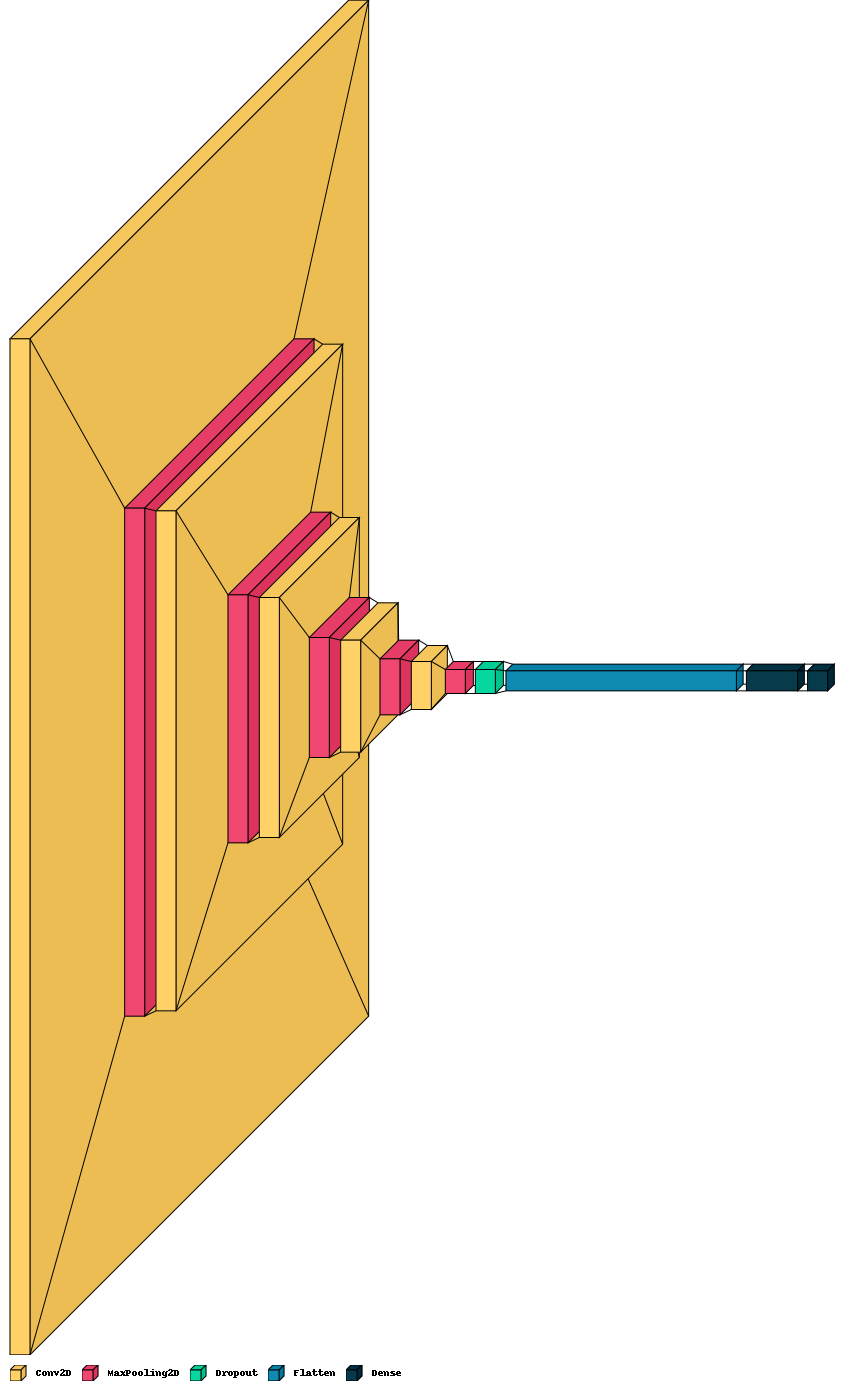

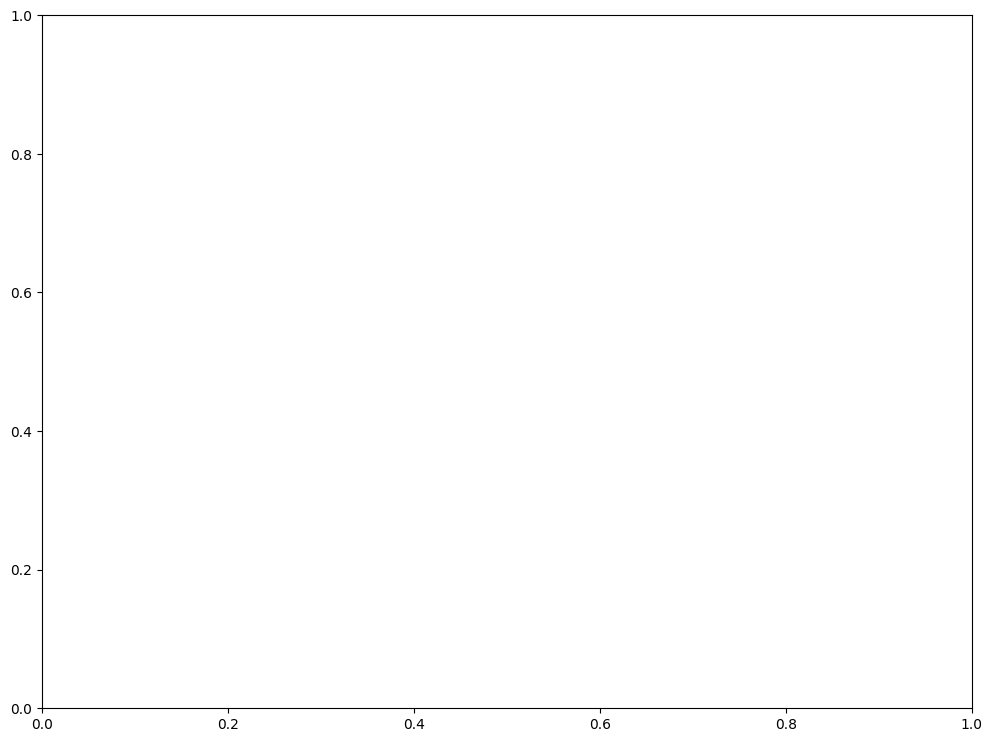

In [ ]:
import visualkeras
import matplotlib.pyplot as plt

# Visualizar la arquitectura del modelo con leyenda y descripciones de capa
vis = visualkeras.layered_view(model, legend=True)

# Configurar el tamaño de la figura
fig, ax = plt.subplots(figsize=(12, 9))

# Guardar la figura en un archivo
vis.save('modelo_visualizado_CNN_MODIFICADO.png')

# Mostrar la visualización
vis.show()

**CODIGO PARA RENOMBRAR IMAGENES**

In [ ]:
import os
import zipfile

# Ruta del archivo ZIP cargado en Google Colab
archivo_zip = '/content/plastic.zip'

# Ruta de la carpeta donde se extraerán los archivos
carpeta_destino = '/content/'

# Ruta de la carpeta dentro del archivo ZIP donde están las imágenes
carpeta_interna = 'plastic'

# Lista de extensiones de archivo de imágenes compatibles
extensiones_validas = ['.jpg', '.jpeg', '.png']

# Prefijo para los nombres de las imágenes
prefijo = 'plastic-'

# Crear la carpeta de destino si no existe
os.makedirs(carpeta_destino, exist_ok=True)

# Extraer el archivo ZIP
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    # Extraer solo la carpeta interna con las imágenes
    zip_ref.extractall(carpeta_destino, members=[m for m in zip_ref.namelist() if m.startswith(carpeta_interna)])

# Función para renombrar imágenes en la carpeta
def renombrar_imagenes():
    contador = 1
    carpeta_imagenes = os.path.join(carpeta_destino, carpeta_interna)
    for archivo in os.listdir(carpeta_imagenes):
        if any(archivo.lower().endswith(ext) for ext in extensiones_validas):
            nuevo_nombre = f"{prefijo}{contador:03d}"
            viejo_path = os.path.join(carpeta_imagenes, archivo)
            nuevo_path = os.path.join(carpeta_imagenes, f"{nuevo_nombre}{os.path.splitext(archivo)[1]}")
            os.rename(viejo_path, nuevo_path)
            contador += 1
            print(f"Renombrado: {archivo} -> {nuevo_nombre}")

# Llamar a la función para renombrar imágenes
renombrar_imagenes()



Renombrado: IMG-20230823-WA0029.jpg -> plastic-001
Renombrado: IMG-20230823-WA0014.jpg -> plastic-002
Renombrado: IMG-20230823-WA0025.jpg -> plastic-003
Renombrado: IMG-20230823-WA0036.jpg -> plastic-004
Renombrado: IMG-20230823-WA0026.jpg -> plastic-005
Renombrado: IMG-20230823-WA0027.jpg -> plastic-006
Renombrado: IMG-20230823-WA0018.jpg -> plastic-007
Renombrado: IMG-20230823-WA0028.jpg -> plastic-008
Renombrado: IMG-20230823-WA0030.jpg -> plastic-009
Renombrado: IMG-20230823-WA0008.jpg -> plastic-010
Renombrado: IMG-20230823-WA0016.jpg -> plastic-011
Renombrado: IMG-20230823-WA0021.jpg -> plastic-012
Renombrado: IMG-20230823-WA0012.jpg -> plastic-013
Renombrado: IMG-20230823-WA0022.jpg -> plastic-014
Renombrado: IMG-20230823-WA0024.jpg -> plastic-015
Renombrado: IMG-20230823-WA0019.jpg -> plastic-016
Renombrado: IMG-20230823-WA0034.jpg -> plastic-017
Renombrado: IMG-20230823-WA0017.jpg -> plastic-018
Renombrado: IMG-20230823-WA0035.jpg -> plastic-019
Renombrado: IMG-20230823-WA0009

In [ ]:
import shutil

# Ruta de la carpeta a descargar
carpeta_a_descargar = '/content/plastic'

# Nombre del archivo ZIP a crear
nombre_archivo_zip = 'plastic.zip'

# Comprimir la carpeta en un archivo ZIP
shutil.make_archive(nombre_archivo_zip, 'zip', carpeta_a_descargar)

print(f"Carpeta comprimida en: {nombre_archivo_zip}")


Carpeta comprimida en: plastic.zip
